In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    recall_score, f1_score, roc_auc_score,
    accuracy_score, precision_score,
    roc_curve, precision_recall_curve, auc,
    ConfusionMatrixDisplay, confusion_matrix,
    mean_squared_error
)
from xgboost import XGBRegressor, XGBClassifier
import optuna
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load data (Tram)
data = pd.read_csv("/Users/tbhuynh/Desktop/UNC_PHD/STOR665/2025_NBA_Project/nba_processed.csv")
# Check basic info
shape_info = data.shape
columns_info = data.columns.tolist()
preview_info = data.head()

shape_info, columns_info, preview_info

((656, 56),
 ['Year',
  'Lower Seed',
  'Higher Seed',
  'Lower Seed Rk',
  'Lower Seed MP',
  'Lower Seed FG',
  'Lower Seed FGA',
  'Lower Seed FG%',
  'Lower Seed 3P',
  'Lower Seed 3PA',
  'Lower Seed 3P%',
  'Lower Seed 2P',
  'Lower Seed 2PA',
  'Lower Seed 2P%',
  'Lower Seed FT',
  'Lower Seed FTA',
  'Lower Seed FT%',
  'Lower Seed ORB',
  'Lower Seed DRB',
  'Lower Seed TRB',
  'Lower Seed AST',
  'Lower Seed STL',
  'Lower Seed BLK',
  'Lower Seed TOV',
  'Lower Seed PF',
  'Lower Seed PTS',
  'Higher Seed Rk',
  'Higher Seed MP',
  'Higher Seed FG',
  'Higher Seed FGA',
  'Higher Seed FG%',
  'Higher Seed 3P',
  'Higher Seed 3PA',
  'Higher Seed 3P%',
  'Higher Seed 2P',
  'Higher Seed 2PA',
  'Higher Seed 2P%',
  'Higher Seed FT',
  'Higher Seed FTA',
  'Higher Seed FT%',
  'Higher Seed ORB',
  'Higher Seed DRB',
  'Higher Seed TRB',
  'Higher Seed AST',
  'Higher Seed STL',
  'Higher Seed BLK',
  'Higher Seed TOV',
  'Higher Seed PF',
  'Higher Seed PTS',
  'Net Wins',
  

In [3]:
# Define real basketball stats (no Rk)
stat_columns = [
    'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
    'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'
]

# Create difference features
for stat in stat_columns:
    high_col = f'Higher Seed {stat}'
    low_col = f'Lower Seed {stat}'
    if high_col in data.columns and low_col in data.columns:
        data[f'diff_{stat}'] = data[high_col] - data[low_col]

# Drop unnecessary columns
drop_cols = [col for col in data.columns if (
    col.startswith('Round_') or 
    any(col == f'Higher Seed {stat}' for stat in stat_columns) or 
    any(col == f'Lower Seed {stat}' for stat in stat_columns)
)]
data = data.drop(columns=drop_cols)

data.head()

,Year,Lower Seed,Higher Seed,Lower Seed Rk,Higher Seed Rk,Net Wins,diff_MP,diff_FG,diff_FGA,diff_FG%,...,diff_FT%,diff_ORB,diff_DRB,diff_TRB,diff_AST,diff_STL,diff_BLK,diff_TOV,diff_PF,diff_PTS
0,2024,1,8,2,26,3,-0.9,-4.1,-4.6,-0.022,...,0.011,-1.4,-2.6,-4.0,-1.1,0.7,-3.2,0.8,1.1,-10.5
1,2024,4,5,20,24,1,-0.3,-1.3,-2.3,-0.003,...,-0.006,0.7,-1.6,-1.0,-3.3,0.8,0.6,1.1,2.2,-2.1
2,2024,3,6,4,1,-2,-1.2,3.9,4.2,0.020,...,0.008,0.7,-3.4,-2.7,4.3,0.9,0.9,0.0,2.2,4.3
3,2024,2,7,19,15,2,0.6,0.2,0.7,-0.001,...,0.046,-1.7,-0.6,-2.2,0.5,1.0,1.9,-1.2,2.7,1.8
4,2024,1,8,3,13,4,-1.2,-2.0,-1.9,-0.013,...,-0.054,1.6,0.4,2.0,-0.1,-0.2,-2.0,0.3,-0.4,-5.0


In [14]:
# XGBoost
# Train/test split
X = data.drop(columns=['Net Wins'])
y = data['Net Wins']

# Encode labels (important for classifier)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=665)

# Define Optuna Objective for Classification
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.6, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.5),  # Less aggressive pruning
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 0.5),  # Mild L1
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 2),  # Mild L2
        "objective": "multi:softmax",
        "num_class": len(np.unique(y_encoded)),
        "random_state": 665,
        "n_jobs": -1 # faster running
    }
    
    model = XGBClassifier(**params, eval_metric='merror') 
    model.fit(X_train, y_train)
    
    # mse directly
    preds_encoded = model.predict(X_test)
    
    preds = label_encoder.inverse_transform(preds_encoded)
    y_true = label_encoder.inverse_transform(y_test)
    
    mse = mean_squared_error(y_true, preds)
    return mse  

# Run Optuna
study = optuna.create_study(direction="minimize") 
study.optimize(objective, n_trials=30)

# Best hyperparameters
print("Best hyperparameters found:", study.best_params)

# Retrain final model
best_params = study.best_params
best_params["random_state"] = 665
best_params["n_jobs"] = -1
best_params["objective"] = "multi:softmax"
best_params["num_class"] = len(np.unique(y_encoded))

xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_train, y_train)

# Predict
xgb_preds_encoded = xgb_model.predict(X_test)

xgb_acc = accuracy_score(y_test, xgb_preds_encoded)
print(f"XGBoost Accuracy: {xgb_acc:.4f}")

# Decode
xgb_preds = label_encoder.inverse_transform(xgb_preds_encoded)
y_test_decoded = label_encoder.inverse_transform(y_test)

xgb_mse = mean_squared_error(y_test_decoded, xgb_preds)
print(f"XGBClassifier Final Test MSE: {xgb_mse:.4f}")


[I 2025-04-26 20:14:18,902] A new study created in memory with name: no-name-dd1ffe72-2abb-4514-8112-caa6c8200126
[I 2025-04-26 20:14:23,555] Trial 0 finished with value: 6.6395939086294415 and parameters: {'n_estimators': 860, 'max_depth': 6, 'learning_rate': 0.01604998711407834, 'subsample': 0.597257402573866, 'colsample_bytree': 0.968464201190096, 'gamma': 0.29164622642324733, 'reg_alpha': 0.3591754789610066, 'reg_lambda': 1.7606107095971386}. Best is trial 0 with value: 6.6395939086294415.
[I 2025-04-26 20:14:24,473] Trial 1 finished with value: 7.4873096446700504 and parameters: {'n_estimators': 140, 'max_depth': 10, 'learning_rate': 0.0642405311540245, 'subsample': 0.8403727214125027, 'colsample_bytree': 0.9822873267321224, 'gamma': 0.33816625398188793, 'reg_alpha': 0.4595549052195712, 'reg_lambda': 1.1744838188096791}. Best is trial 0 with value: 6.6395939086294415.
[I 2025-04-26 20:14:25,817] Trial 2 finished with value: 7.0456852791878175 and parameters: {'n_estimators': 500, 

[I 2025-04-26 20:15:01,605] Trial 21 finished with value: 6.16243654822335 and parameters: {'n_estimators': 580, 'max_depth': 5, 'learning_rate': 0.010621538218897445, 'subsample': 0.7210433460151419, 'colsample_bytree': 0.6624852409982448, 'gamma': 0.23780461300091768, 'reg_alpha': 0.4434674272274348, 'reg_lambda': 0.9808680307313797}. Best is trial 21 with value: 6.16243654822335.
[I 2025-04-26 20:15:06,319] Trial 22 finished with value: 6.695431472081219 and parameters: {'n_estimators': 640, 'max_depth': 5, 'learning_rate': 0.022582248665445073, 'subsample': 0.7091528339493598, 'colsample_bytree': 0.6985474272404664, 'gamma': 0.153547605182967, 'reg_alpha': 0.4690996981044416, 'reg_lambda': 0.9627081319899822}. Best is trial 21 with value: 6.16243654822335.
[I 2025-04-26 20:15:10,790] Trial 23 finished with value: 6.934010152284264 and parameters: {'n_estimators': 440, 'max_depth': 5, 'learning_rate': 0.02020753685174038, 'subsample': 0.6656825070258163, 'colsample_bytree': 0.739060

Best hyperparameters found: {'n_estimators': 580, 'max_depth': 5, 'learning_rate': 0.010621538218897445, 'subsample': 0.7210433460151419, 'colsample_bytree': 0.6624852409982448, 'gamma': 0.23780461300091768, 'reg_alpha': 0.4434674272274348, 'reg_lambda': 0.9808680307313797}
XGBoost Accuracy: 0.2792
XGBClassifier Final Test MSE: 6.1624


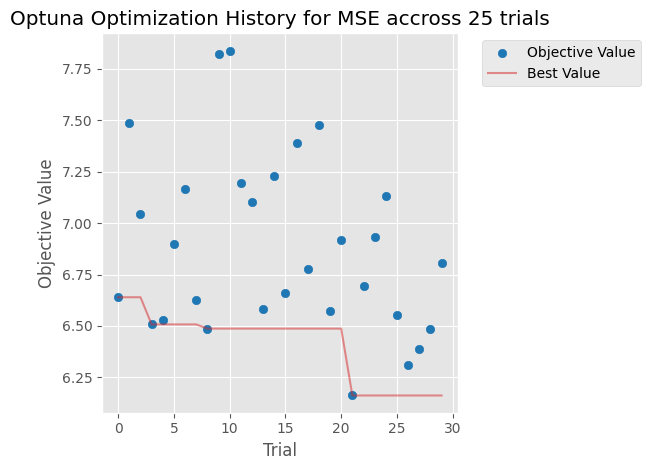

In [15]:
# Plot how MSE changed across 25 trials
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optuna Optimization History for MSE accross 25 trials")
plt.tight_layout()
plt.show()

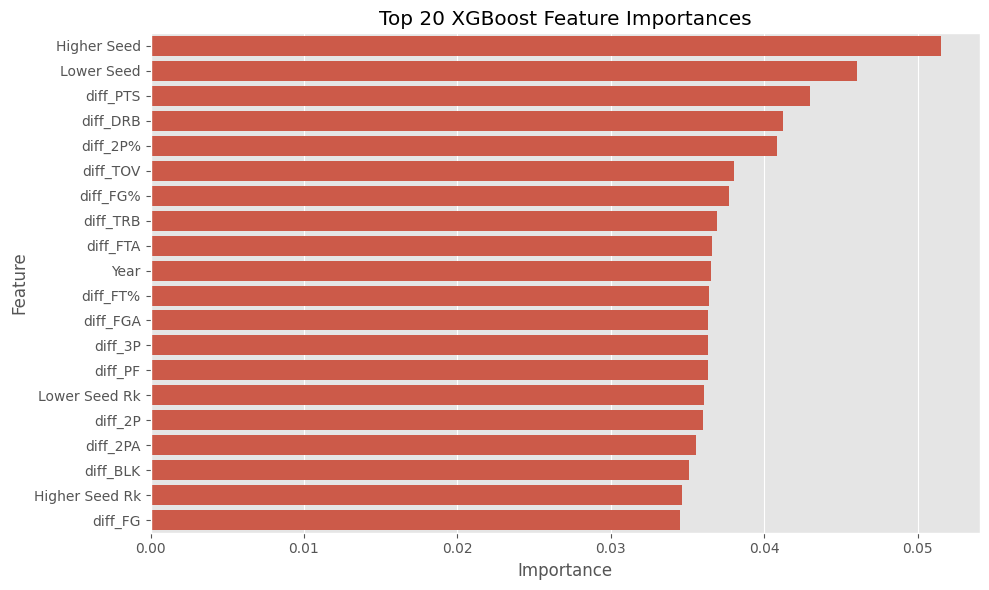

In [16]:
# Plot feature importance from XGBoost model
# Get feature importances
importances = xgb_model.feature_importances_
features = X.columns

# Combine and sort
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(20))
plt.title('Top 20 XGBoost Feature Importances')
plt.tight_layout()
plt.show()

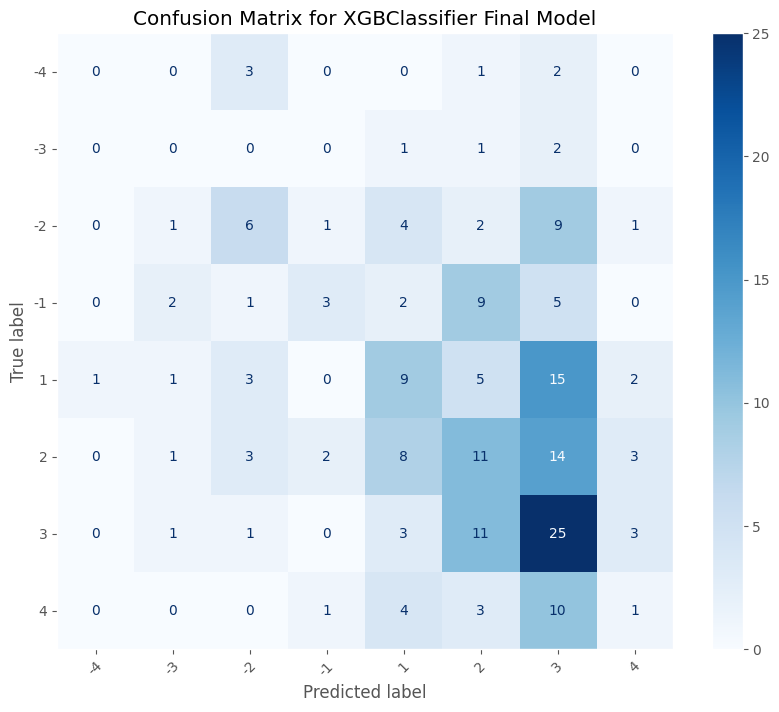

In [17]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues', colorbar=True)
    plt.title('Confusion Matrix for XGBClassifier Final Model')
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.show()

plot_confusion_matrix(y_test_decoded, xgb_preds, labels=sorted(np.unique(y_test_decoded)))